# An unimodal OncotypeDX predictor from 3D medical image data
### Sub-title: The execution script to predict OncotypeDX risk score using 3D medical image data
#### Description: 유방암의 3D 진단영상 데이터를 분석하여 OncotypeDX 위험지수를 예측하는 모델 구동 파이썬 스크립트 코드 입니다. 본 구동 스크립트와 함께 신규 입력 데이터의 OncotypeDX 위험지수를 예측할 기구축된 예측모델 (파일명: model.unimodal_MRI_OncoDX_predictor.hdf5)이 동봉되어 있습니다.

### Step 1. Loading packages
>#### Description: 예측모델 구동에 필요한 패키지 전반을 로딩합니다. 아래 코드를 CTRL + Enter로 실행하십시오. 패키지가 설치되어 있지 않으면 conda install 또는 pip install 명령으로 설치하시기 바랍니다.

In [3]:
#import dependencies
import pandas as pd
import nibabel as nib
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from matplotlib import pyplot

### Step 2. Loading meta data
>#### Description: OncotypeDX 위험지수를 예측할 입력데이터의 파일리스트를 로딩합니다. 파일 리스트 목록이 저장된 파일은 텍스트 형식입니다. 아래 코드에서 파일명 및 경로를 지정하십시오.
>#### 파일 리스트 목록의 컬럼양식은 다음과 같습니다:
>*[순서번호, 환자ID, nii파일이름, nii파일이_저장된_root경로, 환자연령]*
>#### 자세한 형식은 동봉된 예제 데이터의 양식("UC_001.nii_meta.unimodal.txt")을 참조하시기 바랍니다.
>#### 주의 1: OncotypeDX risk group을 예측하기 위해서는 meta data에 환자의 연령(Age) 정보가 있어야 합니다.
>#### 주의 2: 입력 3D medical image의 형식은 (80,80,30) shape의 NIFTI (.nii) 형식 입니다. 입력데이터가 다른 파일형식이라면 유틸리티가 동봉된 유스케이스(UC_EXTRA.UTILITIES) 폴더의 프로그램들을 참조하여 NIFTI 형식으로 변환 후 본 스크립트를 구동하시기 바랍니다.

In [2]:
# load meta data
meta_filename = "./UC_001.nii_meta.unimodal.txt"

bcrDataFrame = pd.read_csv(meta_filename, sep="\t", index_col=0)

column_header_list = list(bcrDataFrame.columns)

patient_list = list(bcrDataFrame[column_header_list[0]])
nii_list = list(bcrDataFrame[column_header_list[1]])
data_root_folder = list(bcrDataFrame[column_header_list[2]])
age_list = list(bcrDataFrame[column_header_list[3]])

print("#n of nii files: " + str(len(nii_list)))

#n of nii files: 703


### Step 3. Loading user input files of nifti-formatted images
>#### Description: 메타데이터 목록에서 지정되어 있는 사용자가 입력한 nifti 형식의 3D 이미지를 읽어 numpy array 형식으로 저장합니다.아래 코드에서 저장하고자 하는 numpy array 파일명(변수: nparrays_filename)을 지정하고, CTRL + Enter로 실행하십시오.

In [3]:
# load nii files
nparrays_filename = "nparrays_of_niis.npy"
samples_files = []
for i in range(len(nii_list)):
    samples_files.append(data_root_folder[i] + "/"  + nii_list[i])

# collects numpy arrays and normalizes
image_nparrays = []
for i in range(len(samples_files)):
    img = nib.load(samples_files[i]).get_fdata()
    img /= np.max(img)
    nparray = np.array(img, dtype=np.float32)
    x = nparray.shape[0]
    y = nparray.shape[1]
    z = nparray.shape[2]
    converted_array = nparray.reshape((x,y,z))
    image_nparrays.append(converted_array)
image_nparrays = np.array(image_nparrays)

# change data type to "np.float32"
image_nparrays = image_nparrays.astype(np.float32)

print("image_nparrays shape is" + str(image_nparrays.shape))

# save numpy arrays
np.save(nparrays_filename,image_nparrays)

image_nparrays shape is(703, 80, 80, 30)


### Step 4. Display of 3D medical images
>#### Description: 사용자가 입력한 3D 이미지 데이터 중, 첫번째 데이터를 화면 출력합니다. CTRL + Enter로 실행하십시오.
>#### 주의: 입력 3D medical image의 형식은 (80,80,30) shape 입니다. 입력데이터가 다른 파일형식이라면 유틸리티가 동봉된 유스케이스(UC_EXTRA.UTILITIES) 폴더의 프로그램들을 참조하여 NIFTI 형식으로 변환 후 본 스크립트를 구동하시기 바랍니다.

Dimension of 3D image is: (80, 80, 30)


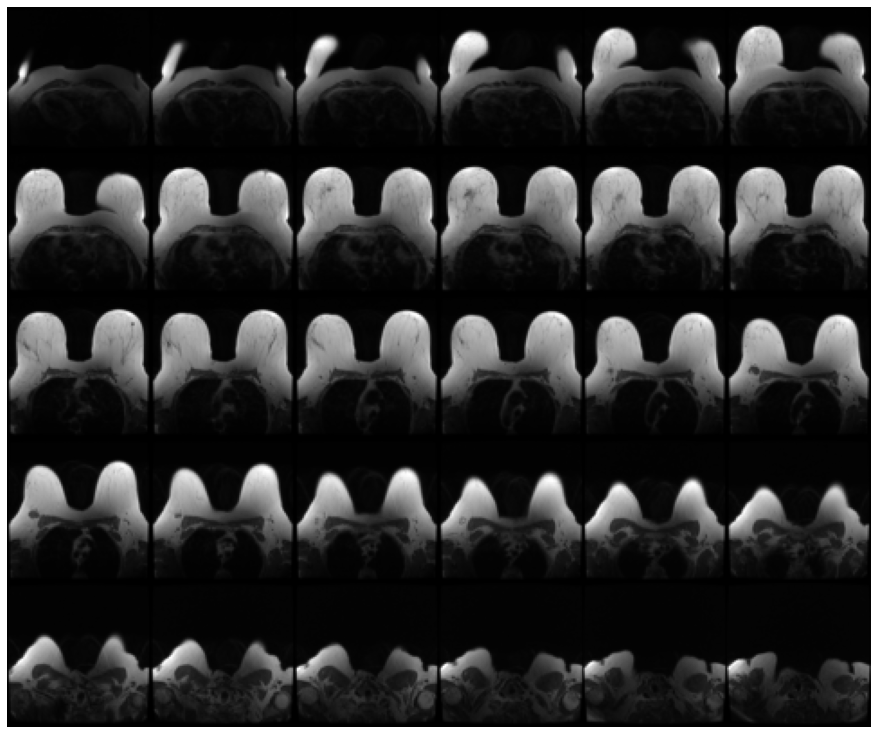

In [4]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = pyplot.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    pyplot.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    pyplot.show()

image = image_nparrays[0]
print("Dimension of 3D image is:", image.shape)

# Visualize montage of slices.
plot_slices(5, 6, 80, 80, image[:, :, :30])

### Step 5. Loading prediction model
>#### Description: 사전에 훈련된 예측모델(모델의 파일이름 변수:model_filename)을 로딩하고 모델의 성능을 평가합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [5]:
#load prediction model
model_filename = 'model.unimodal_MRI_OncoDX_predictor.hdf5'
from keras.models import load_model
model = load_model(model_filename)

2023-07-08 19:03:50.557443: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 19:03:51.461346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46371 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


### Step 6. Perform the predictor
>#### Description: 사용자가 입력한 데이터로 OncotypeDX 위험지수를 예측합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [6]:
#Predicting of OncotypeDX risk score of individual
prd_list = np.argmax(model.predict(image_nparrays), axis=1)

for idx in range(len(prd_list)):
    if (prd_list[idx] == 0):
        print("Risk group of", patient_list[idx], ":", prd_list[idx], "(OncotypeDX range: 0 ~ 5)")
    elif (prd_list[idx] == 1):
        print("Risk group of", patient_list[idx], ":", prd_list[idx], "(OncotypeDX range: 6 ~ 10)")
    elif (prd_list[idx] == 2):
        print("Risk group of", patient_list[idx], ":", prd_list[idx], "(OncotypeDX range: 11 ~ 15)")
    elif (prd_list[idx] == 3):
        print("Risk group of", patient_list[idx], ":", prd_list[idx], "(OncotypeDX range: 16 ~ 20)")
    elif (prd_list[idx] == 4):
        print("Risk group of", patient_list[idx], ":", prd_list[idx], "(OncotypeDX range: 21 ~ 25)")
    elif (prd_list[idx] == 5):
        print("Risk group of", patient_list[idx], ":", prd_list[idx], "(OncotypeDX range: 26 ~ 30)")
    elif (prd_list[idx] == 6):
        print("Risk group of", patient_list[idx], ":", prd_list[idx], "(OncotypeDX range: 31 ~ )")

2023-07-08 19:04:14.220123: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-07-08 19:04:16.898528: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Risk group of Breast_MRI_003 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_003 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_003 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_003 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_003 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_003 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_004 : 2 (OncotypeDX range: 11 ~ 15)
Risk group of Breast_MRI_004 : 2 (OncotypeDX range: 11 ~ 15)
Risk group of Breast_MRI_004 : 2 (OncotypeDX range: 11 ~ 15)
Risk group of Breast_MRI_004 : 2 (OncotypeDX range: 11 ~ 15)
Risk group of Breast_MRI_004 : 2 (OncotypeDX range: 11 ~ 15)
Risk group of Breast_MRI_006 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_006 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_006 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_006 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_006 : 1 (OncotypeDX range: 6 ~ 10)
Risk group of Breast_MRI_006 : 1 (O

### Step 7. Risk group stratification
>#### Description: 예측된 OncotypeDX 위험지수로 환자의 risk groups (Low, Intermediate, High)을 분류하고 화면에 출력합니다. 이 때, meta data에는 환자의 연령(Age) 정보가 있어야 합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [7]:
#Risk group stratification (considering age)
for i in range(len(prd_list)):
    if age_list[i] <= 50:
        if prd_list[i] >=0 and prd_list[i] <=1:
            prd_tag = "LOW"
        elif prd_list[i] >1 and prd_list[i] <=3:
            prd_tag = "INTERMIDIATE"
        else:
            prd_tag = "HIGH"
    else:
        if prd_list[i] >=0 and prd_list[i] <=1:
            prd_tag = "LOW"
        elif prd_list[i] >1 and prd_list[i] <=4:
            prd_tag = "INTERMIDIATE"
        else:
            prd_tag = "HIGH"
    print("Risk group stratificaion of", patient_list[i], ":", prd_tag)

Risk group stratificaion of Breast_MRI_003 : LOW
Risk group stratificaion of Breast_MRI_003 : LOW
Risk group stratificaion of Breast_MRI_003 : LOW
Risk group stratificaion of Breast_MRI_003 : LOW
Risk group stratificaion of Breast_MRI_003 : LOW
Risk group stratificaion of Breast_MRI_003 : LOW
Risk group stratificaion of Breast_MRI_004 : INTERMIDIATE
Risk group stratificaion of Breast_MRI_004 : INTERMIDIATE
Risk group stratificaion of Breast_MRI_004 : INTERMIDIATE
Risk group stratificaion of Breast_MRI_004 : INTERMIDIATE
Risk group stratificaion of Breast_MRI_004 : INTERMIDIATE
Risk group stratificaion of Breast_MRI_006 : LOW
Risk group stratificaion of Breast_MRI_006 : LOW
Risk group stratificaion of Breast_MRI_006 : LOW
Risk group stratificaion of Breast_MRI_006 : LOW
Risk group stratificaion of Breast_MRI_006 : LOW
Risk group stratificaion of Breast_MRI_006 : LOW
Risk group stratificaion of Breast_MRI_008 : HIGH
Risk group stratificaion of Breast_MRI_008 : HIGH
Risk group stratificai